<a href="https://colab.research.google.com/github/mandyss10/VCA/blob/main/Practica0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
route = '/content/gdrive/MyDrive/GIA/VCA/P0'

print("Current directory:")
!pwd

print(f"\nWe now change the directory to '{route}'")
%cd $route
!pwd

print("\nAnd here there are our files:")
!ls -lasth



Current directory:
/content

We now change the directory to '/content/gdrive/MyDrive/GIA/VCA/P0'
/content/gdrive/MyDrive/GIA/VCA/P0
/content/gdrive/MyDrive/GIA/VCA/P0

And here there are our files:
total 4.0K
4.0K drwx------ 2 root root 4.0K Feb 10 10:06 MNIST


In [ ]:
from torchvision import datasets

train = datasets.MNIST(route, train=True, download=True)
test = datasets.MNIST(route, train=False, download=True)

In [ ]:
print(train)
print(test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/gdrive/MyDrive/GIA/VCA/P0
    Split: Train
Dataset MNIST
    Number of datapoints: 10000
    Root location: /content/gdrive/MyDrive/GIA/VCA/P0
    Split: Test


10000
(<PIL.Image.Image image mode=L size=28x28 at 0x79F10849A650>, 7)


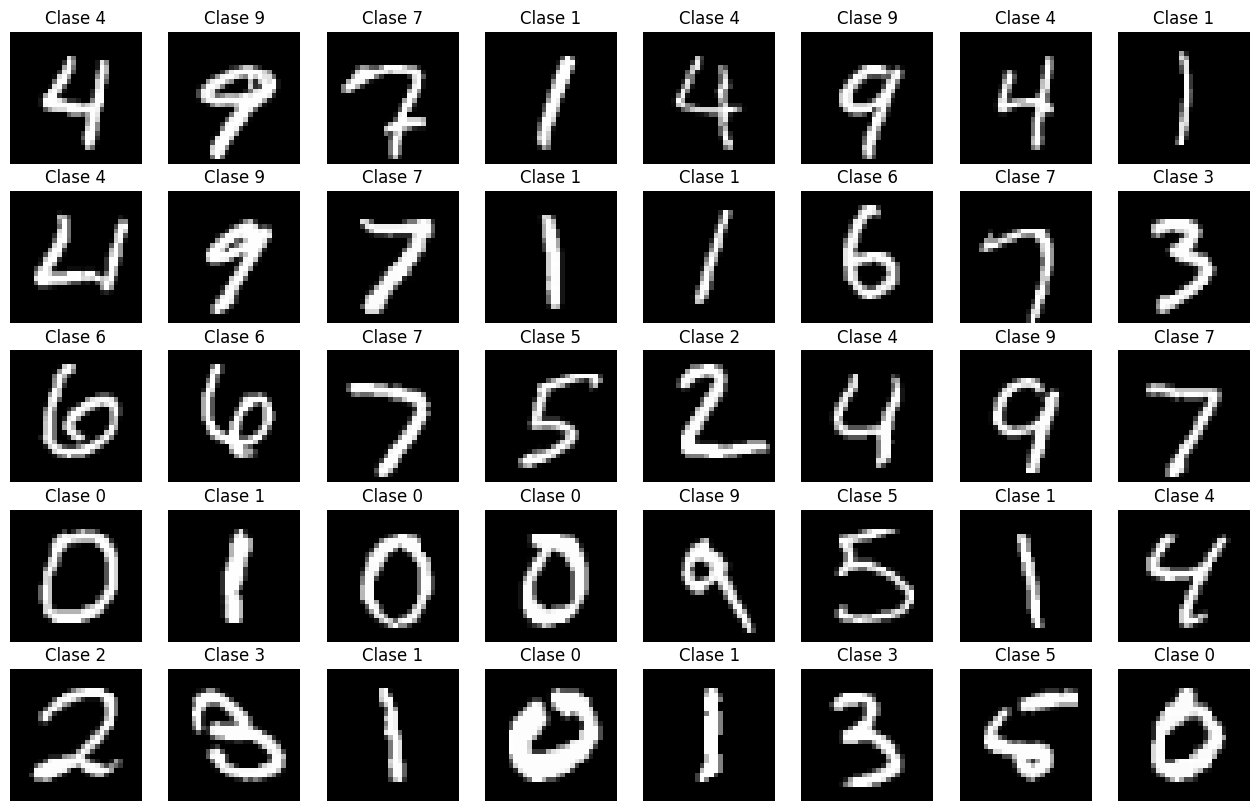

In [ ]:
import matplotlib.pyplot as plt
from numpy import random

print(len(test))
print(test[0])

cols, rows = 8, 5
figure = plt.figure(figsize=(cols*2, rows*2))
view = random.permutation(cols * rows + 1)

for i in range(1, cols * rows + 1):
    sample, label = test[view[i]]
    figure.add_subplot(rows, cols, i)
    plt.title(f'Clase {label}')
    plt.axis("off")
    plt.imshow(sample, cmap="gray")
plt.show()



In [ ]:
from torchvision import models
model = models.alexnet(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 113MB/s]


In [ ]:

# Revisar la nueva estructura del modelo
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
import torch.nn as nn
num_features = model.classifier[6].in_features
model.fc = nn.Linear(num_features, 10)  # 10 clases para los dígitos

In [ ]:
from torchvision import transforms as t

trans = t.Compose([
                   t.Lambda(lambda x: x.convert("RGB")),
                   t.Resize(224),
                   t.ToTensor()
])

input, target = test[0]
print("This is the dataset 'input'")
print(input)

input = trans(input).unsqueeze_(0)
# The unsqueeze is because the network need an input of [N,3,W,H],
# where N is the number of training/testing images: in this case 1.
# The transform output will be a PyTorch tensor of shape [3,128,128].
# The unsqueeze gives a tensor of shape [1,3,128,128].

print("\nThis is the transformed 'input'")
print(input.shape)

output = model(input)

print("\nThis is the output of the network")
print(output.shape)

This is the dataset 'input'
<PIL.Image.Image image mode=L size=28x28 at 0x79F107F37F90>

This is the transformed 'input'
torch.Size([1, 3, 224, 224])

This is the output of the network
torch.Size([1, 1000])


In [ ]:
import torch.nn as nn
modelf = model.features  # Extraer la parte convolucional

# Crear un modelo personalizado para clasificar 10 dígitos
mymodel = nn.Sequential(
    modelf,
    nn.AdaptiveAvgPool2d(output_size=(1, 1)),  # Pooling para reducir a [batch, 256, 1, 1]
    nn.Flatten(),  # Aplanar a [batch, 256]
    nn.Linear(256, 1024),  # Capa totalmente conectada
    nn.ReLU(),
    nn.Linear(1024, 10)  # Salida con 10 clases
)


In [ ]:
print(mymodel[0][0])
for name, param in mymodel[0][0].named_parameters():
  print(f"- {name}: {param.shape}")

old_layer = mymodel[0][0]
mymodel[0][0] = nn.Conv2d(1, 64, 3, padding=1)
mymodel[0][0].weight.data = old_layer.weight.sum(dim=1, keepdim=True)
mymodel[0][0].bias.data = old_layer.bias

print(mymodel[0][0])
for name, param in mymodel[0][0].named_parameters():
  print(f"- {name}: {param.shape}")


Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
- weight: torch.Size([64, 3, 11, 11])
- bias: torch.Size([64])
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
- weight: torch.Size([64, 1, 11, 11])
- bias: torch.Size([64])


In [ ]:
class myCNN(nn.Module):

    def __init__(self):
        super(myCNN, self).__init__()

        self.convlayer1 = nn.Sequential(
            nn.Conv2d(1,32,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.convlayer2 = nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(64*6*6,600), # We assume the 6x6 resulting from input images of 28x28
            nn.ReLU()
            )

        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = x.view(-1,64*6*6) # Like flattening in-place
        x = self.fc1(x)
        x = self.fc2(x)
        return nn.log_softmax(x,dim=1)

In [ ]:
mycnn = myCNN()

print(mycnn)


myCNN(
  (convlayer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convlayer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=2304, out_features=600, bias=True)
    (1): ReLU()
  )
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)


In [ ]:
mytransforms = t.Compose([
                          t.Resize(64),
                          t.ToTensor(),
                          t.Normalize((0.5,),(0.5,))
])

test = datasets.MNIST(route, train=False, download=True, transform = mytransforms)



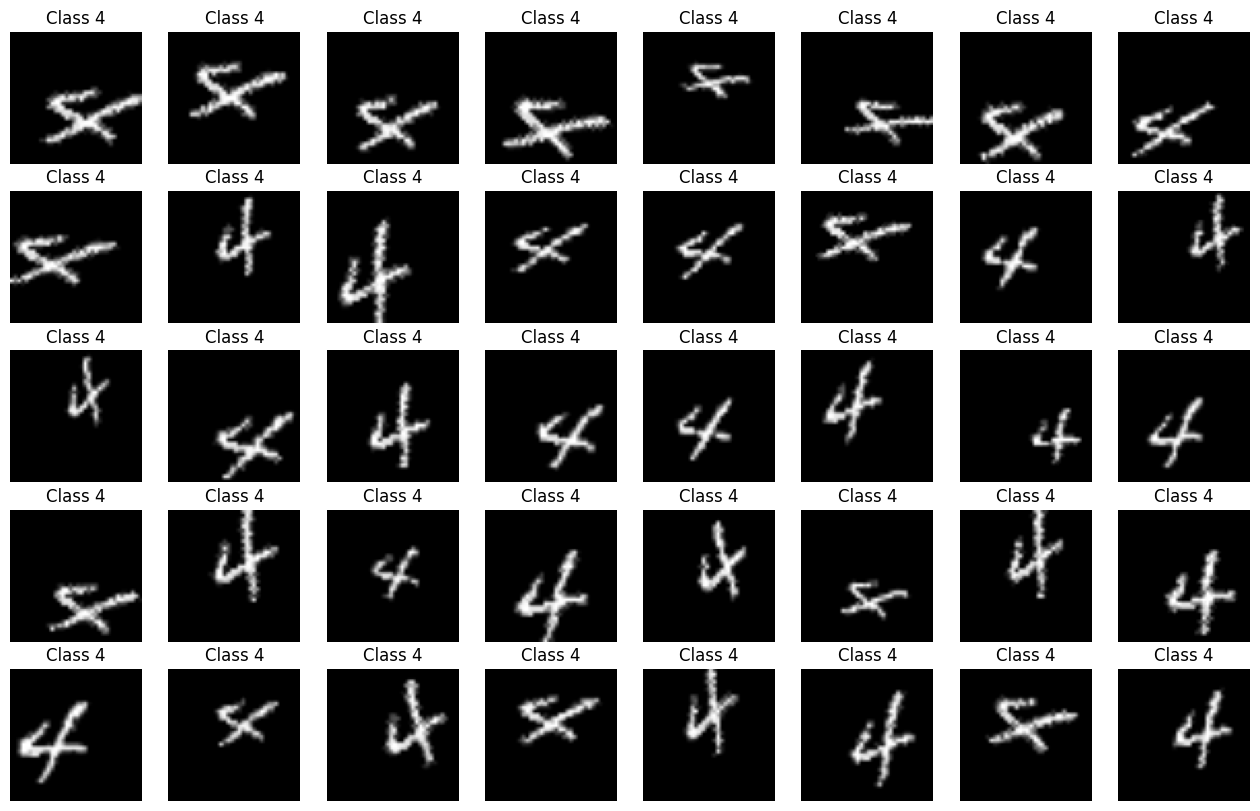

In [ ]:
myaugmentation = t.Compose([
                             t.Pad(4),
                             t.RandomAffine(degrees=45, translate=(0.2, 0.2), scale=(0.75,1.25), shear=15),
                             t.ColorJitter(brightness=(0.2,0.8), contrast=(0.2, 0.8)),
                             mytransforms
])

train = datasets.MNIST(route, train=True, download=True, transform=myaugmentation)

sample_idx = random.randint(0, len(train))
cols, rows = 8, 5

fig, axes = plt.subplots(rows, cols,figsize =(cols*2, rows*2) )

# Loading the same sample over and over again gives different transforms
for axrow in axes:
  for ax in axrow:
    sample,label = train[sample_idx]
    ax.imshow(sample[0,...], cmap='gray')
    ax.axis('off')
    ax.title.set_text(f'Class {label}')



In [ ]:
from torch.utils.data import DataLoader

dataloader = DataLoader(train, batch_size=128, shuffle=True, num_workers=2)

#We can iterate over the dataset as:
counter = 0
for sample, target in dataloader:
  print(f"Minibacth {counter}: ({sample.shape}, {target.shape}).")
  counter += 1
  if counter == 10:
    print("... It would continue for much longer until an epoch is completed.")
    break


Minibacth 0: (torch.Size([128, 1, 64, 64]), torch.Size([128])).
Minibacth 1: (torch.Size([128, 1, 64, 64]), torch.Size([128])).
Minibacth 2: (torch.Size([128, 1, 64, 64]), torch.Size([128])).
Minibacth 3: (torch.Size([128, 1, 64, 64]), torch.Size([128])).
Minibacth 4: (torch.Size([128, 1, 64, 64]), torch.Size([128])).
Minibacth 5: (torch.Size([128, 1, 64, 64]), torch.Size([128])).
Minibacth 6: (torch.Size([128, 1, 64, 64]), torch.Size([128])).
Minibacth 7: (torch.Size([128, 1, 64, 64]), torch.Size([128])).
Minibacth 8: (torch.Size([128, 1, 64, 64]), torch.Size([128])).
Minibacth 9: (torch.Size([128, 1, 64, 64]), torch.Size([128])).
... It would continue for much longer until an epoch is completed.


# Entrenamiento de la red

In [ ]:
# Autograd Example. Make two tensors and operate with them
import torch

a = torch.tensor([1., 2.], requires_grad=True)
b = torch.tensor([5., 6.], requires_grad=True)

# Look at the current gradients
print(f"Tensor 'a': {a}")
print(f"Gradients wrt tensor 'a': {a.grad}")

print(f"Tensor 'b': {b}")
print(f"Gradients wrt tensor 'b': {b.grad}")

# Pass it through the "network"

q = 3*a**3-b**2           # 3a^3-b^2 -> dq/da = 9a^2 ; dq/db = -2b

print(f"Tensor 'q': {q}")
print(f"Tensor 'q.sum()': {q.sum()}")


# Compute the backpropagation gradients, first integrating all the q outputs

q.sum().backward()

print(f"After backpropagation:")
print(f"Gradients wrt tensor 'a': {a.grad}; Theoretical gradients: {9*a**2}")
print(f"Gradients wrt tensor 'b': {b.grad}; Theoretical gradients: {-2*b}")


Tensor 'a': tensor([1., 2.], requires_grad=True)
Gradients wrt tensor 'a': None
Tensor 'b': tensor([5., 6.], requires_grad=True)
Gradients wrt tensor 'b': None
Tensor 'q': tensor([-22., -12.], grad_fn=<SubBackward0>)
Tensor 'q.sum()': -34.0
After backpropagation:
Gradients wrt tensor 'a': tensor([ 9., 36.]); Theoretical gradients: tensor([ 9., 36.], grad_fn=<MulBackward0>)
Gradients wrt tensor 'b': tensor([-10., -12.]); Theoretical gradients: tensor([-10., -12.], grad_fn=<MulBackward0>)


In [ ]:
from torch import optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
mymodel.to(device)                     # Place the model into the GPU

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mymodel.parameters(), lr=1e-4)  # Intizalize the optimizer with the network parameters and learning rate

for epoch in range(3):                           # Iterate a given number of epochs, or control with another condition
  for i,data in enumerate(dataloader):            # Iterate over the batches in the dataset
    samples = data[0].to(device)                  # Place the data into the GPU
    targets = data[1].to(device)                  # Place the targets into the GPU

    output = mymodel(samples)                     # Compute the training samples output
    loss = criterion(output, targets)             # Compute the loss

    optimizer.zero_grad()                         # Reset the old gradients accumulated in the buffer from previous iteration
    loss.backward()                               # Backpropagate the error, which accumulates the gradients for the batch
    optimizer.step()                              # Update the model parameters, according to the optimizer rule

    if i%200 == 0:
      _, predicted = torch.max(output,1)
      total = targets.size(0)
      correct = (predicted == targets).sum().item()
      print(f"epoch:{epoch}, mini-batch: {i}: Training loss: {loss.item()}, accuracy: {correct/total}")


cuda:0
epoch:0, mini-batch: 0: Training loss: 2.311887264251709, accuracy: 0.15625
epoch:0, mini-batch: 200: Training loss: 0.31725671887397766, accuracy: 0.9375
epoch:0, mini-batch: 400: Training loss: 0.20314747095108032, accuracy: 0.9375
epoch:1, mini-batch: 0: Training loss: 0.1271699070930481, accuracy: 0.9609375
epoch:1, mini-batch: 200: Training loss: 0.15157784521579742, accuracy: 0.9609375
epoch:1, mini-batch: 400: Training loss: 0.15145893394947052, accuracy: 0.953125
epoch:2, mini-batch: 0: Training loss: 0.11144517362117767, accuracy: 0.9609375
epoch:2, mini-batch: 200: Training loss: 0.06858992576599121, accuracy: 0.984375
epoch:2, mini-batch: 400: Training loss: 0.07553017884492874, accuracy: 0.984375



# Test de la red

Una vez entrenada la red, podemos realizar un bucle similar para agregar algunas métricas sobre el conjunto de test. Por ejemplo:

In [ ]:
def accuracy(outputs, targets):
    _, predicted = outputs.max(1)
    total = targets.size(0)
    correct = (predicted == targets).sum().item()
    return correct/total

testloader = DataLoader(test, batch_size=128, shuffle=False, num_workers=2)

mymodel.eval() #  This notifies all the layers in the model to put themselves
             # into evaluation mode, just in case there are some with different
             # behaviour during training and testing

mean_acc = 0
with torch.no_grad(): # This disables autograd
  for i, (samples, targets) in enumerate(testloader):
    samples = samples.to(device)
    targets = targets.to(device)

    outputs = mymodel(samples)

    this_acc = accuracy(outputs, targets)
    mean_acc += this_acc

  mean_acc /= (i+1)

print(f"Model accuracy on the test set is {mean_acc*100} %")

Model accuracy on the test set is 97.75514240506328 %


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision import models

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformaciones
basic_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalización específica de MNIST
])

data_augmentation = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.9, 1.1)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Cargar datasets
train_data_basic = datasets.MNIST(root="./data", train=True, download=True, transform=basic_transforms)
train_data_aug = datasets.MNIST(root="./data", train=True, download=True, transform=data_augmentation)
test_data = datasets.MNIST(root="./data", train=False, download=True, transform=basic_transforms)

# Cargar DataLoaders
batch_size = 128
train_loader_basic = DataLoader(train_data_basic, batch_size=batch_size, shuffle=True)
train_loader_aug = DataLoader(train_data_aug, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Función para obtener modelo (preentrenado o desde cero)
def get_model(pretrained=True):
    model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1 if pretrained else None)
    model.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)  # Ajuste para imágenes en escala de grises

    # Si es preentrenado, congelar las capas convolucionales
    if pretrained:
        for param in model.features.parameters():
            param.requires_grad = False

    model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)  # Ajuste para MNIST (10 clases)
    return model.to(device)

# Función de entrenamiento
def train_model(model, train_loader, epochs=3, pretrained=True):
    criterion = nn.CrossEntropyLoss()
    lr = 0.0001 if pretrained else 0.001  # Tasa de aprendizaje más baja para modelo preentrenado
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.6f}")
    return model

# Función de evaluación
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Entrenamiento de los cuatro modelos
models_results = {}

print("\nEntrenando modelo preentrenado sin data augmentation...")
model_pretrained_basic = train_model(get_model(pretrained=True), train_loader_basic)
models_results['Preentrenado Sin Aug'] = evaluate_model(model_pretrained_basic, test_loader)

print("\nEntrenando modelo preentrenado con data augmentation...")
model_pretrained_aug = train_model(get_model(pretrained=True), train_loader_aug)
models_results['Preentrenado Con Aug'] = evaluate_model(model_pretrained_aug, test_loader)

print("\nEntrenando modelo desde cero sin data augmentation...")
model_scratch_basic = train_model(get_model(pretrained=False), train_loader_basic, pretrained=False)
models_results['Desde Cero Sin Aug'] = evaluate_model(model_scratch_basic, test_loader)

print("\nEntrenando modelo desde cero con data augmentation...")
model_scratch_aug = train_model(get_model(pretrained=False), train_loader_aug, pretrained=False)
models_results['Desde Cero Con Aug'] = evaluate_model(model_scratch_aug, test_loader)

# Comparación de resultados
print("\nResultados de accuracy:")
for key, value in models_results.items():
    print(f"{key}: {value:.2%}")


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 471kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.30MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.36MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw


Entrenando modelo preentrenado sin data augmentation...


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 124MB/s]


Epoch 1, Loss: 0.268743
Epoch 2, Loss: 0.107359
Epoch 3, Loss: 0.086242

Entrenando modelo preentrenado con data augmentation...
Epoch 1, Loss: 0.360784
Epoch 2, Loss: 0.166740
Epoch 3, Loss: 0.139487

Entrenando modelo desde cero sin data augmentation...
Epoch 1, Loss: 0.318170
Epoch 2, Loss: 0.079132
Epoch 3, Loss: 0.063464

Entrenando modelo desde cero con data augmentation...
Epoch 1, Loss: 0.451444
Epoch 2, Loss: 0.118430
Epoch 3, Loss: 0.098623

Resultados de accuracy:
Preentrenado Sin Aug: 98.13%
Preentrenado Con Aug: 98.16%
Desde Cero Sin Aug: 98.75%
Desde Cero Con Aug: 99.16%
